# Importing Packages

In [29]:
# If necessary, install packages
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
#import packages
import numpy as np
import pandas as pd
import gdown
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import psycopg2
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
import gensim
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from scipy.stats import pearsonr

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# file IDs and table namesfor lobbying data files from Google Drive
lob_rpt = ('1CIq7XwaFTJmnUKdAvYyh53Et2XSJRX9d', 'lob_rpt')
lob_lobbyist = ('1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p', 'lob_lobbyist')
lob_lobbying = ('19Jef89spXbkExNpYA-s_e8GRii-0tReu', 'lob_lobbying')
lob_issue = ('18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq', 'lob_issue')
lob_indus = ('1yldZYLcZTLIMQ5Xa-e-ecGgQGFWv5n4A', 'lob_indus')
lob_bills = ('1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1', 'lob_bills')
lob_agency = ('1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0', 'lob_agency')
CatCodeReference = ('1vfVA-v-lUMuykF9efl2oDN5DJK2t1PwA', 'CatCodeReference')
CandidateIds = ('1k2lhAcuSQbn5z7NN3USPEbX_Rg5VV_Ky', 'CandidateIds')
congress_bill_data_id = ('1-MnzV0iZ2FPYiuQgOmggjmXvxGmBzYV8', 'congress_bill_data')
tweet_data = ('1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T','tweets_cleaned')
sponsor_tweet_match = ('1jlP28xifZx74RkWLhVPAEqooH11Ak6mA','sponsor_matches')

In [ ]:
def load_csv(table, save_file=False, file_path=None, gzip=False):
    '''
    Downloads a large CSV file from Google Drive into a Pandas DataFrame.
    
    Parameters:
        file_info (tuple): A tuple containing the Google Drive file ID and the table name.
        save_file (bool): If True, the file is saved. If False, it is deleted after loading.
        file_path (str, optional): The directory path where the file should be saved. Defaults to current directory.

    Returns:
        pd.DataFrame: The loaded Pandas DataFrame.
    '''
    file_id, table_name = table
    
    # Set filename as the table name
    temp_file = f'{table_name}.csv'
    
    # If a file path is provided, join it with the filename
    if file_path:
        temp_file = os.path.join(file_path, temp_file)

    # Construct Google Drive download URL
    url = f'https://drive.google.com/uc?export=download&id={file_id}'

    # Download the file
    gdown.download(url, temp_file, quiet=False)

    # Load the CSV file into a Pandas DataFrame
    if gzip == False:
        df = pd.read_csv(temp_file,header=None)
    else:
        df = pd.read_csv(temp_file,header=None, compression='gzip')

    # Remove the file if save_file is False
    if not save_file:
        os.remove(temp_file)

    return df

## Data Cleaning

In [32]:
# Creating function to visualize key aspects of each dataframe. 
def glimpse(df):
    print(f'\n Shape: {df.shape}')
    print(f'\n Columns: {list(df.columns)}')
    print(f'\n Data types:\n{df.dtypes}')
    
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    
    print(f'\n Missing values:\n{missing[missing > 0]}')
    print(f'\n Missing values (%):\n{missing_percent[missing_percent > 0].round(2)}')
    
    print(f'\n First 5 rows:\n{df.head()}')
    print(f'\n Last 5 rows:\n{df.tail()}')


### Lobbying Data

In [35]:
df_lobbying = load_csv(lob_lobbying, save_file = False)
df_lobbying.columns = ['UniqID','Registrant_Raw','Registrant','IsLobbyingFirm','Client_raw','Client','UItorg','Amount','Catcode','Source','Self','IncludeNSFS','Use','Ind','Year','Type','Typelong','Affiliate']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=19Jef89spXbkExNpYA-s_e8GRii-0tReu
From (redirected): https://drive.google.com/uc?export=download&id=19Jef89spXbkExNpYA-s_e8GRii-0tReu&confirm=t&uuid=4d57ba19-c29b-4499-83cf-cf769cb49156
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_lobbying.csv
100%|██████████| 351M/351M [00:12<00:00, 27.1MB/s] 
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/4143072805.py:34: DtypeWarning: Columns (7,11,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file,header=None)


In [ ]:
#Dropping unecessary columns
df_lobbying = df_lobbying.drop(
['Registrant_Raw', #Same as Registrant
 'Client_raw', # Same as Client
 'Source', # Irrelevant to analysis
 'Typelong' # Same as Type
], axis=1)

# Removing all records from lobbying dataframe without an ID
df_lobbying = df_lobbying.dropna(subset=['UniqID'])

# Capitalizing all inputs in Catcode column
df_lobbying['Catcode'] = df_lobbying['Catcode'].str.upper()

# Replacing missing values in selected boolean columns with 'n'
boolean_columns = ['IsLobbyingFirm','Affiliate','IncludeNSFS','Ind']
df_lobbying[boolean_columns] = df_lobbying[boolean_columns].fillna(value='n')

# Changing datatype of columns
df_lobbying['Amount'] = pd.to_numeric(df_lobbying['Amount'], errors='coerce')
df_lobbying = df_lobbying.dropna(subset=['Amount'])
df_lobbying['Year'] = df_lobbying['Year'].astype('int')
df_lobbying[boolean_columns] = df_lobbying[boolean_columns].apply(lambda col: col.map({'y': True, 'n': False}).astype(bool))

# Dropping all lobbying records with Use == n, as these reports have been amendent/updated and a more recent report is avaliable.  
df_lobbying = df_lobbying[df_lobbying['Use'] != 'n']
df_lobbying = df_lobbying.drop('Use',axis=1)

# Only including records after 2011.
df_lobbying = df_lobbying[df_lobbying['Year'] >= 2011]
df_lobbying = df_lobbying.drop('Affiliate',axis=1) # Dropping the Affiliate column as all records are equal to False after slicing. 

In [ ]:
# Extract quarter
df_lobbying['Quarter'] = 'Q' + df_lobbying['Type'].str.extract(r'(\d)')[0]

# Extract report type based on suffix in 'Type' column
df_lobbying['ReportType'] = df_lobbying['Type'].apply(lambda x: 
    'Standard Report' if len(x) == 2 else
    'Amendment' if x.endswith('a') else
    'Amendment (No Activity)' if x.endswith('an') else
    'No Activity' if x.endswith('n') else
    'Termination' if x.endswith('t') else
    'Termination Amendment' if x.endswith('ta') else
    'Termination (No Activity)' if x.endswith('tn') else
    'Unknown')

df_lobbying.drop('Type',axis=1) # Dropping 'Type' column as it is uneccessary now. 

,UniqID,Registrant,IsLobbyingFirm,Client,UItorg,Amount,Catcode,Self,IncludeNSFS,Ind,Year,Quarter,ReportType
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,AstraZeneca Pharmaceuticals,False,AstraZeneca Pharmaceuticals,AstraZeneca PLC,1370000.0,H4300,x,False,True,2021,Q4,Amendment
1,84ad3a9e-5864-4227-a802-e268fbf37237,David L Horne LLC,True,Multifamily Lenders Council,Multifamily Lenders Council,15000.0,F4600,n,False,True,2021,Q4,Standard Report
2,85b111b1-5d2e-4107-bc24-0921316e29a5,Echelon Government Affairs,True,Albers Group,Albers Group,10000.0,Y4000,n,False,True,2021,Q4,Standard Report
3,87822a14-12de-478c-a34d-010fa503e539,Western Telecommunications Alliance,False,Western Telecommunications Alliance,Western Telecommunications Alliance,75000.0,C4000,p,False,True,2021,Q4,Standard Report
4,87ff989d-9d12-4fef-84ef-ab69cd616894,Financial Executives International,False,Financial Executives International,Financial Executives International,21650.0,F5000,p,False,True,2021,Q4,Standard Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544068,0854dd96-ed91-4219-99d9-b84bf06ee2f8,American Express,False,American Express,American Express,440000.0,F1400,p,False,True,2022,Q4,Standard Report
1544069,086b65ba-0abe-4ed0-a3e9-a66c9ecc96a3,BL Partners Group,True,CTIA,CTIA,30000.0,C4300,i,False,False,2022,Q4,Standard Report
1544070,b01b51ba-d426-4750-ad00-0ea3c5aa2317,Vectis DC,True,"City of Montebello, CA","City of Montebello, CA",20000.0,X3000,n,False,True,2022,Q4,Standard Report
1544071,b0235c16-0a34-4e06-be62-f42a3bf52d6a,Nickles Group,True,Walmart Inc,Walmart Inc,80000.0,G4300,i,False,False,2022,Q4,Standard Report


### Industry

In [38]:
df_industry = load_csv(lob_indus, save_file = False)
df_industry.columns = ['Client','Sub','Total','Year','Catcode']

Downloading...
From: https://drive.google.com/uc?export=download&id=1yldZYLcZTLIMQ5Xa-e-ecGgQGFWv5n4A
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_indus.csv
100%|██████████| 20.3M/20.3M [00:02<00:00, 8.96MB/s]


In [39]:
# Only including records after 2011.
df_industry = df_industry[df_industry['Year'] >= 2011]

# Capitalizing all inputs in Catcode column
df_industry['Catcode'] = df_industry['Catcode'].str.upper()

#### Catcode References

In [ ]:
df_catcode_references = load_csv(CatCodeReference, save_file = False)
df_catcode_references.columns = ['Catcode','Catname','Catorder','Industry','Sector','SectorLong']

Downloading...
From: https://drive.google.com/uc?export=download&id=1vfVA-v-lUMuykF9efl2oDN5DJK2t1PwA
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/CatCodeReference.csv
100%|██████████| 43.0k/43.0k [00:00<00:00, 1.01MB/s]


In [41]:
# merging catcode reference with industry column
df_industry = pd.merge(df_industry, df_catcode_references[['Catcode','Catname', 'Industry', 'Sector']],
                     left_on='Catcode', right_on='Catcode', how='left')

### Agency

In [42]:
df_agency = load_csv(lob_agency, save_file=False)
df_agency.columns = ['UniqID','AgencyID','Agency']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0
From (redirected): https://drive.google.com/uc?export=download&id=1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0&confirm=t&uuid=69e951a3-e5ac-439e-9849-24fd519077bc
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_agency.csv
100%|██████████| 256M/256M [00:12<00:00, 20.0MB/s] 


### Issues

In [45]:
df_issue = load_csv(lob_issue, save_file=False)
df_issue.columns = ['SI_ID','UniqID','IssueID','Issue','SpecificIssue','Year']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq
From (redirected): https://drive.google.com/uc?export=download&id=18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq&confirm=t&uuid=40ec25bc-59b6-4ca1-b1ed-4cb91579e734
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_issue.csv
100%|██████████| 787M/787M [00:27<00:00, 28.4MB/s] 


In [46]:
# Only including records after 2011.
df_issue = df_issue[df_issue['Year'] >= 2011]

# Retrieving records with missing values for SpecificIssue 
specific_issue_missing = df_issue[df_issue['SpecificIssue'].isna()]

# Imputing missing values in SpecificIssue column with value from Issue column. 
df_issue['SpecificIssue'] = df_issue['SpecificIssue'].fillna(df_issue['Issue'])

# Dropping IssueID column as this has no value for our analysis. 
df_issue.drop('IssueID',axis=1)

,SI_ID,UniqID,Issue,SpecificIssue,Year
0,3001624,02e92bd6-0159-495e-9d00-8a490a0be8be,Disaster & Emergency Planning,Issues affecting manufacturer of railroad and ...,2022
1,3001625,02e92bd6-0159-495e-9d00-8a490a0be8be,Environment & Superfund,Issues affecting manufacturer of railroad and ...,2022
2,3001626,02e92bd6-0159-495e-9d00-8a490a0be8be,"Labor, Antitrust & Workplace",Issues affecting manufacturer of railroad and ...,2022
3,3001627,02e92bd6-0159-495e-9d00-8a490a0be8be,Roads & Highways,Issues affecting manufacturer of railroad and ...,2022
4,3001628,02e92bd6-0159-495e-9d00-8a490a0be8be,Railroads,Issues affecting manufacturer of railroad and ...,2022
...,...,...,...,...,...
3009859,3076640,0a62db56-bdc4-4f4c-9329-5b420066f53c,Small Business,Women's Business Center program reauthorizatio...,2022
3009860,3076641,0a6de630-f472-4dc2-a796-b58d67831573,Defense,Issues related to tungsten manufacturing,2022
3009861,3076642,0a7f2d03-7d7a-450c-b20a-a48c0fa93e92,Automotive Industry,Issues related to autonomous vehicles Cybersec...,2022
3009862,3076643,0a7f2d03-7d7a-450c-b20a-a48c0fa93e92,Banking,Financial services issues Industrial loan bank...,2022


#### Bills

In [43]:
df_bills = load_csv(lob_bills, save_file=False)
df_bills.columns = ['B_ID', 'SI_ID', 'CongNo', 'Bill_Name']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1
From (redirected): https://drive.google.com/uc?export=download&id=1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1&confirm=t&uuid=914e77a4-d45a-42cb-920f-939dcd64ffc9
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_bills.csv
100%|██████████| 219M/219M [00:07<00:00, 29.1MB/s] 


In [47]:
# Importing Year column from the issues dataframe 
# this is to impute missing values for congress number by cross-referencing Year with a dictionary containing Year and Congress No. at the time. 
df_bills = df_bills.merge(df_issue[['SI_ID', 'Year']], on='SI_ID', how='left')

# Dictionary mapping Congress by year. Retrieved from: https://www.congress.gov/help/field-values/congresses
congress_number_by_year = {
2025: 119.0, 2026: 119.0,2023: 118.0,2024: 118.0,2021: 117.0,2022: 117.0,2019: 116.0,2020: 116.0,
2017: 115.0,2018: 115.0,2015: 114.0,2016: 114.0,2013: 113.0,2014: 113.0,2011: 112.0,
2012: 112.0,2009: 111.0,2010: 111.0,2007: 110.0,2008: 110.0,2005: 109.0,2006: 109.0,
2003: 108.0,2004: 108.0,2001: 107.0,2002: 107.0,1999: 106.0,2000: 106.0,1998: 105.0
}

# Impute missing values
df_bills['CongNo'] = df_bills['CongNo'].fillna(df_bills['Year'].map(congress_number_by_year))

# Dropping 'Year' column again
df_bills = df_bills.drop('Year',axis=1)

# Converting datatype of CongNo column
df_bills['CongNo'] = df_bills['CongNo'].astype('Int64')

In [49]:
# Dropping records with missing value in CongNo, as these records are not connected to Lobby Issues dataframe through Foreign Key - and are hence excessive
df_bills = df_bills.dropna(subset=['CongNo'])

In [ ]:
df_bills['Bill_Name'] = df_bills['Bill_Name'].str.replace(r'^H\.?(\d+)$', r'H.R.\1', regex=True)

### Lobbyist

In [51]:
df_lobbyist = load_csv(lob_lobbyist,save_file=False)
df_lobbyist.columns = ['UniqID','Lobbyist_raw','Lobbyist','LobbyistID','Year','OfficialPosition','CID','Formercongmem']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p
From (redirected): https://drive.google.com/uc?export=download&id=1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p&confirm=t&uuid=00026638-66f3-4c2a-a2eb-86c450744cb5
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_lobbyist.csv
100%|██████████| 410M/410M [00:12<00:00, 34.0MB/s] 


In [52]:
# Only including records after 2011.
df_lobbyist = df_lobbyist[df_lobbyist['Year'] >= 2011]

# Dropping missing values
df_lobbyist = df_lobbyist.dropna(subset=['LobbyistID'])
df_lobbyist = df_lobbyist.dropna(subset=['Year']) # Dropping this record as well as it does not have any UniqId

# Dropping uneccessary column
df_lobbyist = df_lobbyist.drop('Lobbyist_raw',axis=1)

# Chaging data type of Year column
df_lobbyist['Year'] = df_lobbyist['Year'].astype('Int64')

# Imputing missing values in 'Formercongmem' column -- if CID = Blank --> 'n', if CID != Blank --> 'y'
df_lobbyist.loc[df_lobbyist['Formercongmem'].isna(), 'Formercongmem'] = df_lobbyist['CID'].apply(
    lambda x: 'n' if pd.isna(x) else 'y')

# Changing data type of Formercongmem column to Boolean
df_lobbyist['Formercongmem'] = df_lobbyist['Formercongmem'].map({'y': True, 'n': False}).astype(bool)

# Imputing missing values for CID column
df_lobbyist['CID'] = df_lobbyist['CID'].fillna(value='Not Congress Member')

In [53]:
# Pringint unique values in official position column
print(len(df_lobbyist['OfficialPosition'].unique()))

# Considering the amount of missing values and unique values - OfficialPosition column is dropped due to providing small value to further analysis
df_lobbyist = df_lobbyist.drop('OfficialPosition',axis=1)

41623


#### Candidate IDs

In [54]:
df_candidate = load_csv(CandidateIds,save_file=False)
df_candidate.columns = ['CID', 'CRPName', 'Party', 'DistIDRunFor', 'FECCandID']

Downloading...
From: https://drive.google.com/uc?export=download&id=1k2lhAcuSQbn5z7NN3USPEbX_Rg5VV_Ky
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/CandidateIds.csv
100%|██████████| 970k/970k [00:00<00:00, 4.51MB/s]


In [55]:
# Merge on the common 'CID' column to include the columns from df_candidate
df_lobbyist = pd.merge(
    df_lobbyist,
    df_candidate[['CID', 'CRPName', 'Party', 'DistIDRunFor', 'FECCandID']],
    on='CID',
    how='left'
)

## Narrowing Scope

In [56]:
# Only including lobbying reports related to specific issues
chosen_issues = ['Health Issues', 'Medical Research & Clin Labs', 'Pharmacy', 'Medicare & Medicaid', 'Science & Technology', 'Taxes']
df_issue = df_issue[df_issue['Issue'].isin(chosen_issues)]

In [57]:
# Dropping lobbying reports that are no longer referenced in df_issue table
df_lobbying = df_lobbying[df_lobbying['UniqID'].isin(df_issue['UniqID'])]

# dropping lobbyist records for lobbyists that are no longer involved in the lobbying reports from cleaned df_lobbying df.
df_lobbyist = df_lobbyist[df_lobbyist['UniqID'].isin(df_lobbying['UniqID'])]

# droppping bills records that are not related to any of the chosen issues. 
df_bills = df_bills[df_bills['SI_ID'].isin(df_issue['SI_ID'])]

# droppping agency records that are not related to any of the current reports. 
df_agency = df_agency[df_agency['UniqID'].isin(df_lobbying['UniqID'])]

# droppping industry records that are not related to any of the current reports.
df_industry = df_industry[df_industry['Catcode'].isin(df_lobbying['Catcode'])]

#### Importing additional information about bills

In [58]:
df_congress_bill_data = load_csv(congress_bill_data_id, save_file=False)
df_congress_bill_data.columns = ['bill_number','congress_number','bill_title','policy_area','introduced_date',
                                 'bill_type','full_bill_code','sponsor_name','sponsor_party','sponsor_bioguide_id']
df_congress_bill_data = df_congress_bill_data.iloc[1:] # dropping first row of dataframe

Downloading...
From: https://drive.google.com/uc?export=download&id=1-MnzV0iZ2FPYiuQgOmggjmXvxGmBzYV8
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/congress_bill_data.csv
100%|██████████| 4.26M/4.26M [00:00<00:00, 9.16MB/s]


In [ ]:
df_congress_bill_data['congress_number'] = df_congress_bill_data['congress_number'].astype('Int64')

df_congress_bill_data = df_congress_bill_data.merge(
    df_bills[['B_ID', 'CongNo', 'Bill_Name']],
    left_on=['full_bill_code', 'congress_number'],
    right_on=['Bill_Name', 'CongNo'],
    how='left'
).drop(columns=['Bill_Name', 'CongNo'],axis = 1)  # Drop duplicate columns

In [60]:
# Dropping bill records we don't have any data sponsor data on. 
df_bills = df_bills[df_bills['B_ID'].isin(df_congress_bill_data['B_ID'])]

## Restructuring Data for Efficiency

#### Main Table

In [ ]:
# Merge all tables on 'UniqID' to capture all required fields
df_master_table = (
    df_lobbying
    .merge(df_agency, on='UniqID', how='left')
    .merge(df_lobbyist, on='UniqID', how='left')
    .merge(df_issue, on='UniqID', how='left')
)

# Select columns with unique identifer frome each relevant table
df_master_table = df_master_table[['UniqID', 'AgencyID', 'LobbyistID', 'SI_ID']].drop_duplicates()

# Add a unique MasterID
df_master_table.insert(0, 'MasterID', range(1001, 1001 + len(df_master_table)))

df_master_table['AgencyID'] = df_master_table['AgencyID'].astype('Int64') # changing data type of AgencyID column

In [ ]:
# we observe that some lobbying instances are not related to a Lobbyist or Agency. 
df_master_table.isnull().sum()
df_master_table[['AgencyID','LobbyistID']] = df_master_table[['AgencyID','LobbyistID']].replace({np.nan: None}) # Replace NaN with None for SQL compatibility

In [63]:
# Include year column in master table
df_master_table = pd.merge(
    df_master_table,
    df_lobbying[['UniqID','Year']],
    on='UniqID',
    how='left'
)

#### Industry Table

In [ ]:
# Ensure all unique combinations of Catcode-Year from the Lobbying dataframe are captured
unique_catcode_years = df_lobbying[['Catcode', 'Year']].drop_duplicates()

# Summarize lobbying data (only including Ind=True records)
lobbying_filtered_summary = (
    df_lobbying[df_lobbying['Ind'] == True]  # Only include records where Ind=True
    .groupby(['Catcode', 'Year'])
    .agg(
        Total_Lobbying_Reported=('Amount', 'sum'),  # Sum lobbying spending that counts towards industry totals
    )
    .reset_index())

# Summarize industry data by Catcode + Year
industry_summary = (
    df_industry.groupby(['Catcode', 'Year'])
    .agg(
        Total_Lobbying_Spending=('Total', 'sum'),  # Sum total spending per industry per year
        Unique_Clients=('Client', 'nunique')  # Count unique clients per industry per year
    )
    .reset_index())

# Ensure all unique Catcode-Year combinations from Lobbying Data exist in the final dataset
df_industry_summary = unique_catcode_years.merge(
    lobbying_filtered_summary, on=['Catcode', 'Year'], how='left').merge(
    industry_summary, on=['Catcode', 'Year'], how='left'
    )

# Fill NaN values with 0 for numerical columns (in case no data exists for that Catcode-Year in a dataset)
df_industry_summary.fillna({'Total_Lobbying_Reported': 0, 'Total_Lobbying_Spending': 0, 'Unique_Clients': 0}, inplace=True)

# Extract unique Catname, Industry, and Sector information per Catcode
df_industry_unique = df_industry[['Catcode', 'Catname', 'Industry', 'Sector']].drop_duplicates()

# Merge additional industry metadata
df_industry_summary = df_industry_summary.merge(
    df_industry_unique,
    on='Catcode',
    how='left'
)


#### Agency Table

In [65]:
# Dropping duplicate entries of AgencyID and Agency combination
df_agency_final = df_agency[['AgencyID', 'Agency']].drop_duplicates()

# Displaying potential duplicates in AgencyID column
df_agency_final[df_agency_final.duplicated(subset=['AgencyID'], keep=False)].sort_values('AgencyID')

# Define the list of (Agency, AgencyID) tuples to drop
to_drop = [
    (54,'Federal Deposit Insurance Commission'),
    (86, 'Postal Rate Commission'),
    (124, 'Defense Security Assistance Agency'),
    (199,'ACCESS Board'),
    (238, 'Office of National Aids Policy')
]

# Drop rows that match both Agency and AgencyID
df_agency_final = df_agency_final[~df_agency_final.apply(tuple, axis=1).isin(to_drop)]


#### Lobbyist Table

In [66]:
df_lobbyist_final = df_lobbyist[['LobbyistID', 'Lobbyist', 'Formercongmem', 'Party']].drop_duplicates()

In [67]:
# Imputing missing values for political party for former congress-men
missing_political_party = {
    'Y0000022381L' : 'R','Y0000014172L' : 'R','Y0000041393L' : 'R','Y0000041198L' : 'D','Y0000031994L' : 'R','Y0000040464L' : 'R',
    'Y0000041214L' : 'D','Y0000040343L' : 'R','Y0000026610L' : 'R','Y0000042045L' : 'R','Y0000041638L' : 'R','Y0000027785L' : 'R',
    'Y0000041137L' : 'D','Y0000009728L' : 'R','Y0000041060L' : 'R','Y0000027979L' : 'R','Y0000040107L' : 'D','Y0000030165L' : 'D',
    'Y0000008316L' : 'R','Y0000041693L' : 'D','Y0000041437L' : 'D','Y0000000158L' : 'R','Y0000040464M' : 'R','Y0000040575L' : 'R',
    'Y0000042027L' : 'D','Y0000009666L' : 'D','Y0000038683L' : 'R','Y0000046534L' : 'R','Y0000041860L' : 'D','Y0000028461L' : 'R',
    'Y0000014475L' : 'D','Y0000017606L' : 'D','Y0000011321L' : 'R','Y0000042041L' : 'R','Y0000041375L' : 'D','Y0000041586L' : 'D',
    'Y0000041364L' : 'D','Y0000017415L' : 'R','Y0000008436L' : 'R','Y0000045198L' : 'R','Y0000006265L' : 'R','Y0000035408L' : 'R',
    'Y0000040391L' : 'R','Y0000041827L' : 'R','Y0000041317L' : 'R','Y0000042035L' : 'D','Y0000040953L' : 'D','Y0000012587L' : 'D',
    'Y0000000545L' : 'D','Y0000005168L' : 'D','Y0000005429L' : 'R','Y0000028048L' : 'R','Y0000039653L' : 'D','Y0000015675L' : 'D',
    'Y0000014080L' : 'D','Y0000041094L' : 'D','Y0000025402L' : 'D','Y0000033912L' : 'R','Y0000027950L' : 'R','Y0000003201L' : 'D',
    'Y0000046532L' : 'D','Y0000027397L' : 'D','Y0000040428L' : 'R','Y0000017752L' : 'D','Y0000000969L' : 'D','Y0000016284L' : 'R',
    'Y0000001540L' : 'D','Y0000008788L' : 'D','Y0000055101L' : 'D','Y0000019350L' : 'R','Y0000028862L' : 'D','Y0000047746L' : 'D',
    'Y0000020586L' : 'D','Y0000007555L' : 'R'
    }

df_lobbyist_final['Party'] = df_lobbyist_final['Party'].fillna(df_lobbyist_final['LobbyistID'].map(missing_political_party))

In [ ]:
# Define a function to handle duplicates based on 'Party' column
def resolve_duplicates(group):
    # If there's only one entry, return it
    if len(group) == 1:
        return group

    # Check if the first occurrence has a missing value in 'Party'
    if pd.isna(group.iloc[0]['Party']):
        return group.iloc[1:]  # Keep the second entry
    else:
        return group.iloc[:1]  # Keep the first entry

df_lobbyist_final = df_lobbyist_final.groupby('LobbyistID', group_keys=False).apply(resolve_duplicates).reset_index(drop=True)

/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3952088457.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_lobbyist_final = df_lobbyist_final.groupby('LobbyistID', group_keys=False).apply(resolve_duplicates).reset_index(drop=True)


#### Issue Table

In [ ]:
# Only keeping necessary columns for new table
df_issue_final = df_issue[['SI_ID','Issue','SpecificIssue']]

df_issue_final = df_issue_final.merge(
    df_bills[['SI_ID','B_ID']],
    on = 'SI_ID',
    how = 'left'
)

#### Bills Table

In [70]:
df_bills_final = df_bills[['B_ID','CongNo','Bill_Name']] # only keeping necessary columns
df_bills_final = df_bills_final[['B_ID', 'CongNo', 'Bill_Name']].drop_duplicates() # Dropping duplicates from dataframe. 

In [ ]:
# checking if all B_ID's from parent table exists in child table. 
missing_b_ids_in_bills = df_issue_final[~df_issue_final['B_ID'].isin(df_bills_final['B_ID'])]
print(missing_b_ids_in_bills['B_ID'].unique()) # all missing ID's from parent table are missing values. 

# checking if all B_ID's in child table table exists in parent table. 
all_b_ids_exist_in_issue = df_bills_final['B_ID'].isin(df_issue_final['B_ID']).all()
print(all_b_ids_exist_in_issue)


[nan]
True


#### Sponsor Table

In [ ]:
df_sponsor = df_congress_bill_data[['sponsor_bioguide_id','B_ID','sponsor_name','sponsor_party']]
df_sponsor.rename(columns={'sponsor_bioguide_id':'SponsorID','sponsor_name':'SponsorName','sponsor_party':'SponsorParty'},inplace=True)

/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/658583622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sponsor.rename(columns={'sponsor_bioguide_id':'SponsorID','sponsor_name':'SponsorName','sponsor_party':'SponsorParty'},inplace=True)


In [ ]:
# checking if all B_ID's from parent table exists in child table. 
missing_b_ids_in_sponsor = df_bills_final[~df_bills_final['B_ID'].isin(df_sponsor['B_ID'])]
print(missing_b_ids_in_sponsor['B_ID'].unique()) # all missing ID's from parent table are missing values. 

# checking if all B_ID's in child table table exists in parent table. 
all_b_ids_exist_in_bills = df_sponsor['B_ID'].isin(df_bills_final['B_ID']).all()
print(all_b_ids_exist_in_bills)

[]
True


In [ ]:
df_sponsor.isnull().sum() # we observe that 95 bills are missing. these are either Reserved for Speaker, or dosen't actually have a Sponsor.

SponsorID       95
B_ID             0
SponsorName     95
SponsorParty    95
dtype: int64

In [76]:
df_sponsor = df_sponsor[['SponsorID','B_ID','SponsorName','SponsorParty']].drop_duplicates() # dropping duplicate records

In [72]:
# check if one bill can be related to multiple sponsors
duplicated_bills = df_sponsor[df_sponsor.duplicated(subset=['B_ID'], keep=False)]
duplicated_bills

,SponsorID,B_ID,SponsorName,SponsorParty


In [77]:
# considering we have a one-to-many relationship between sponsor and bills, we can simply merge the two tables by including sponsor information in the Bills Table. 
df_bills_final = df_bills_final.merge(df_sponsor[['B_ID','SponsorName','SponsorParty']], on = 'B_ID', how = 'left')

### Industry and Lobbying Table

In [ ]:
# Create foreign key for df_industry_summary table my concatenating catcode and year in df_lobbying
df_lobbying['industry_id'] = df_lobbying['Catcode'].astype(str) + '_' + df_lobbying['Year'].astype(str)

# dropping year and catcode column from df_lobbying
df_lobbying = df_lobbying.drop(columns=['Catcode','Year'],axis = 1)

# creating industry_id and dropping year column for df_industry_summary
df_industry_summary['industry_id'] = df_industry_summary['Catcode'].astype(str) + '_' + df_industry_summary['Year'].astype(str)
df_industry_summary = df_industry_summary.drop(columns=['Year'],axis = 1)

## Create Junction Table between Issue and Bills: Issue_Bills

In [ ]:
#create junction dataframe
df_bills_issues = df_issue_final[['SI_ID', 'B_ID']].drop_duplicates()

# cleaning issue table to not reference bills
df_issue_final = df_issue_final.drop(columns=['B_ID'])

In [80]:
df_bills_issues.isnull().sum() # about 15% of issue records are not related to a bill.  
df_bills_issues['B_ID'] = df_bills_issues['B_ID'].replace({np.nan: None}) # Replace NaN with None for SQL compatibility

In [ ]:
#ensure we don't have duplicated entries for PKs in df_bills_final and df_issues_final
df_bills_final[df_bills_final.duplicated(subset='B_ID', keep=False)] # no duplciates
df_issue_final[df_issue_final.duplicated(subset='SI_ID', keep=False)] # duplicats, only keep first occurence of 'SI_ID'
df_issue_final = df_issue_final.drop_duplicates(subset='SI_ID', keep='first')

## Preparing Data for Relational Database Management System (RDBMS)

In [ ]:
# Database connection parameters
host = 'localhost'
database = 'USLobbyism2'
user = 'postgres'
password = 'MasterThesis'
port = 5433


connection = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password,
    port=port 
)

cur = connection.cursor()

# Create the dimension tables
cur.execute('''
    CREATE TABLE IF NOT EXISTS industry_dim (
        industry_id VARCHAR(36) PRIMARY KEY,
        Catcode CHAR(5),
        Catname VARCHAR(50),
        Industry VARCHAR(36),
        Sector VARCHAR(50),
        UniqueClients INT,
        Total_Lobbying_Reported FLOAT,
        Total_Lobbying_Spending FLOAT
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS lobbying_report_dim (
        UniqID VARCHAR(36) PRIMARY KEY,
        Registrant VARCHAR(50),
        IsLobbyingFirm BOOLEAN,
        Client VARCHAR(50),
        UItorg VARCHAR(50),
        Amount FLOAT,
        Self CHAR(1),
        IncludeNSFS BOOLEAN,
        Ind BOOLEAN,
        Quarter CHAR(2),
        ReportType VARCHAR(36),
        industry_id VARCHAR(36),
        FOREIGN KEY (industry_id) REFERENCES industry_dim(industry_id) ON DELETE CASCADE
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS agency_dim (
        AgencyID CHAR(4) PRIMARY KEY,
        Agency VARCHAR(80)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS lobbyist_dim (
        LobbyistID VARCHAR(12) PRIMARY KEY,
        LobbyistName VARCHAR(50),
        Formercongmem BOOLEAN,
        Party CHAR(4)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS bills_dim (
        B_ID VARCHAR(18) PRIMARY KEY,
        BillName CHAR(15),
        CongNo CHAR(3),
        SponsorName VARCHAR(255),
        SponsorParty CHAR(4)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS issue_dim (
        SI_ID BIGINT PRIMARY KEY,
        Issue VARCHAR(50),
        SpecificIssue TEXT
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS bills_issues_junction (
        JunctionID SERIAL PRIMARY KEY,
        B_ID VARCHAR(18),
        SI_ID BIGINT NOT NULL,
        FOREIGN KEY (B_ID) REFERENCES bills_dim(B_ID) ON DELETE SET NULL,
        FOREIGN KEY (SI_ID) REFERENCES issue_dim(SI_ID) ON DELETE CASCADE
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS main_fact (
        MasterID SERIAL PRIMARY KEY,
        UniqID VARCHAR(36) NOT NULL,
        LobbyistID VARCHAR(12),
        SI_ID BIGINT NOT NULL,
        AgencyID CHAR(4),
        Year INT,
        FOREIGN KEY (UniqID) REFERENCES lobbying_report_dim(UniqID) ON DELETE CASCADE,
        FOREIGN KEY (LobbyistID) REFERENCES lobbyist_dim(LobbyistID) ON DELETE SET NULL,
        FOREIGN KEY (SI_ID) REFERENCES issue_dim(SI_ID) ON DELETE CASCADE,
        FOREIGN KEY (AgencyID) REFERENCES agency_dim(AgencyID) ON DELETE SET NULL
    )
''')

# Insert data into tables

cur.executemany('''
    INSERT INTO industry_dim (industry_id, Catcode, Catname, Industry, Sector, UniqueClients, Total_Lobbying_Reported, Total_Lobbying_Spending)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
''', df_industry_summary[['industry_id','Catcode', 'Catname', 'Industry', 'Sector', 'Unique_Clients', 'Total_Lobbying_Reported', 'Total_Lobbying_Spending']].values.tolist())

cur.executemany('''
    INSERT INTO lobbying_report_dim (UniqID, Registrant, IsLobbyingFirm, Client, UItorg, Amount, Self, IncludeNSFS, Ind, Quarter, ReportType, industry_id)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
''', df_lobbying[['UniqID','Registrant','IsLobbyingFirm','Client','UItorg','Amount','Self','IncludeNSFS','Ind','Quarter','ReportType','industry_id']].values.tolist())

cur.executemany('INSERT INTO agency_dim (AgencyID, Agency) VALUES (%s, %s)', df_agency_final[['AgencyID', 'Agency']].values.tolist())
cur.executemany('INSERT INTO lobbyist_dim (LobbyistID, LobbyistName, Formercongmem, Party) VALUES (%s, %s, %s, %s)', df_lobbyist_final[['LobbyistID','Lobbyist', 'Formercongmem', 'Party']].values.tolist())
cur.executemany('INSERT INTO bills_dim (B_ID, BillName, CongNo, SponsorName, SponsorParty) VALUES (%s, %s, %s, %s, %s)', df_bills_final[['B_ID','Bill_Name', 'CongNo','SponsorName','SponsorParty']].values.tolist())
cur.executemany('INSERT INTO issue_dim (SI_ID, Issue, SpecificIssue) VALUES (%s, %s, %s)', df_issue_final[['SI_ID','Issue', 'SpecificIssue']].values.tolist())
cur.executemany('INSERT INTO bills_issues_junction (B_ID, SI_ID) VALUES (%s, %s)', df_bills_issues[['B_ID','SI_ID']].values.tolist())
cur.executemany('INSERT INTO main_fact (MasterID, UniqID, LobbyistID, SI_ID, AgencyID, Year) VALUES (%s, %s, %s, %s, %s, %s)', df_master_table[['MasterID','UniqID','LobbyistID','SI_ID', 'AgencyID','Year']].values.tolist())

# Commit the changes and close the connection
connection.commit()
cur.close()
connection.close()

# NLP Processing

### Specific Issue Processing

In [ ]:
# Download models and resources if necessary
# nltk.download('stopwords')
# !python -m spacy download en_core_web_sm
# spacy.cli.download('en_core_web_sm')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# retrieve specific issue text
texts_specific_issue = df_issue_final['SpecificIssue']

# function for preprocessing with tqdm og nlp.pipe
def preprocess_texts(texts):
    processed = []
    for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts)):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and token.lemma_.lower() not in stop_words and len(token.lemma_) > 2
        ]
        processed.append(' '.join(tokens))
    return processed

# apply function
df_issue_final['PreprocessedIssue'] = preprocess_texts(texts_specific_issue)

# display result
print(df_issue_final[['SpecificIssue', 'PreprocessedIssue']].head())

100%|██████████| 421309/421309 [41:39<00:00, 168.58it/s] 


                                        SpecificIssue  \
0   Issues affecting manufacturer of railroad and ...   
1   Support for education and research of health i...   
3   H.R. 4750, the Performing Artist Tax Parity Ac...   
6   Infectious diseases (generally, no specific le...   
11  Antimicrobial resistance research, infectious ...   

                                    PreprocessedIssue  
0   issue affect manufacturer railroad utility pro...  
1   support education research health issue concer...  
3   performing artist tax parity act patpa america...  
6   infectious disease generally specific legislat...  
11  antimicrobial resistance research infectious d...  


### Tweet Processsing

In [82]:
df_tweets = load_csv(tweet_data,gzip=True)
df_tweets.columns = ['id','screen_name','user_id','text','date']
df_tweets = df_tweets.iloc[1:] # dropping first row of dataframe

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T
From (redirected): https://drive.google.com/uc?export=download&id=1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T&confirm=t&uuid=b7e803c7-f218-40f3-ad42-41e612c9ddf6
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/tweets_cleaned.csv
100%|██████████| 626M/626M [00:28<00:00, 22.0MB/s] 
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_44672/4143072805.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file,header=None, compression="gzip")


In [83]:
df_tweets = df_tweets.dropna(subset=['text'])
df_tweets.isnull().sum()
df_tweets = df_tweets[df_tweets['text'].str.len() > 15] #dropping all tweets with less than 15 characters

In [85]:
df_tweets = df_tweets[df_tweets['text'].str.len() > 15] #dropping all tweets with less than 15 characters

In [ ]:
# function for preprocessing with tqdm og nlp.pipe
def preprocess_texts(texts):
    processed = []
    for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts)):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and token.lemma_.lower() not in stop_words and len(token.lemma_) > 2
        ]
        processed.append(' '.join(tokens))
    return processed

# retrieve specific issue text
texts_tweets = df_tweets['text']

# apply function
df_tweets['preprocessed_text'] = preprocess_texts(texts_tweets)

# display result
print(df_tweets[['text', 'preprocessed_text']].head())

100%|██████████| 6245620/6245620 [9:02:58<00:00, 191.71it/s]   


                                                text  \
1  @ceruleanbill Doesn't mean you're not brillian...   
2  Big dangerous storm hit my sister's neighborho...   
3  @jeffmw Thanks Jeff.  Happy New Year! Here's t...   
4  5,4,3,2,1..happy new year! I know I'm early, b...   
5            Wishing you and yours a Happy New Year!   

                                   preprocessed_text  
1                mean brilliant happy happy new year  
2  big dangerous storm hit sister neighborhood su...  
3  thank jeff happy new year find thing agree nex...  
4  happy new year know early time swear twitter p...  
5                                wish happy new year  


### Visualization Tweet Data

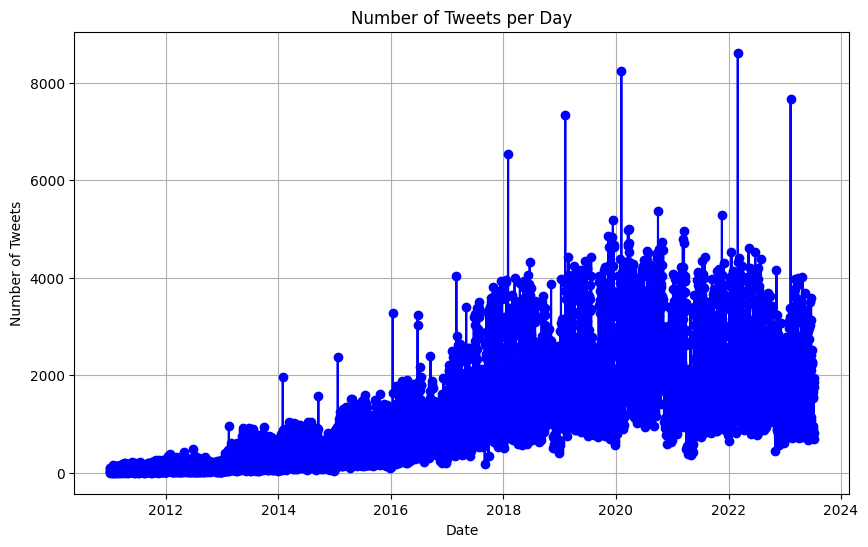

In [ ]:
#Visualizing tweets over time
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

tweet_counts = df_tweets.groupby('date').size()  # Count tweets per day

plt.figure(figsize=(10,6))
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

### Topic Modelling

#### BERTTopic on Issue Data

In [ ]:
# Drop NA and reset index to ensure clean list of documents
issue_documents = df_issue_final['PreprocessedIssue'].dropna().reset_index(drop=True).tolist()

# Initialize the sentence transformer embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Track embedding progress
print(f'Generating embeddings for {len(issue_documents)} documents...')
embeddings = embedding_model.encode(issue_documents, show_progress_bar=True, batch_size=32)

# Configure HDBSCAN for clustering to limit topic count
hdbscan_model = HDBSCAN(
    min_cluster_size=100,  # minimum number of documents within each topic. 
    min_samples=5,        
    metric='euclidean',   # metric used for clustering
    prediction_data=True)

# Initialize BERTopic with the custom HDBSCAN model
topic_model = BERTopic(
    language='english',
    verbose=True,
    hdbscan_model=hdbscan_model)

# Fit BERTopic model using precomputed embeddings
print('Fitting BERTopic model...')
topics, probs = topic_model.fit_transform(issue_documents, embeddings)

# Save topic assignments back into DataFrame
df_issue_final.loc[df_issue_final['PreprocessedIssue'].notna(), 'BERTopic'] = topics

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating embeddings for 420706 documents...


Batches: 100%|██████████| 13148/13148 [09:22<00:00, 23.36it/s]
2025-04-21 21:45:26,002 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic model...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-22 04:42:44,357 - BERTopic - Dimensionality - Completed ✓
2025-04-22 04:42:44,398 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. 

In [6]:
bert_issue_topic_info = topic_model.get_topic_info()

In [ ]:
#extracting information about top words for each topic. 
bert_issue_topics_dict = topic_model.get_topics()
bert_issue_topic_words = []

for topic_num, words in bert_issue_topics_dict.items():
    bert_issue_topic_words.append({
        'Topic': topic_num,
        'Words': ', '.join([word for word, _ in words])
    })
df_topic_words = pd.DataFrame(bert_issue_topic_words)

### LDA on Specific Issue

In [ ]:
texts = df_issue_final['PreprocessedIssue'].dropna().tolist()

# Split preprocessed text into tokens
tokenized_texts = [text.split() for text in texts]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_texts)

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5) # no words that appear in less than 5 documents, or more than 50%

# Create a bag-of-words representation for each document
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train the LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10, # 10 unique topics
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics and their top keywords
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')

# Assign the dominant topic to each document
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    if topic_probs:
        return max(topic_probs, key=lambda x: x[1])[0]
    return -1

# Apply to corpus
df_issue_final.loc[df_issue_final['PreprocessedIssue'].notna(), 'LDATopic'] = [
    get_dominant_topic(bow) for bow in corpus
]

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Topic 0: 0.134*"medicare" + 0.054*"medicaid" + 0.046*"payment" + 0.031*"hospital" + 0.023*"program" + 0.022*"physician" + 0.022*"reimbursement" + 0.020*"coverage" + 0.014*"part" + 0.014*"access"
Topic 1: 0.077*"support" + 0.015*"provide" + 0.014*"service" + 0.013*"increase" + 0.013*"advocate" + 0.013*"use" + 0.013*"house" + 0.011*"senate" + 0.011*"program" + 0.010*"include"
Topic 2: 0.157*"act" + 0.104*"health" + 0.059*"care" + 0.021*"access" + 0.017*"implementation" + 0.016*"public" + 0.014*"patient" + 0.013*"mental" + 0.012*"protection" + 0.012*"affordable"
Topic 3: 0.106*"act" + 0.058*"appropriations" + 0.055*"research" + 0.031*"consolidated" + 0.025*"development" + 0.025*"science" + 0.023*"national" + 0.018*"related" + 0.017*"innovation" + 0.016*"technology"
Topic 4: 0.184*"legislation" + 0.079*"monitor" + 0.041*"regulation" + 0.035*"federal" + 0.025*"specific" + 0.023*"lobby" + 0.022*"activity" + 0.020*"privacy" + 0.018*"administrative" + 0.017*"action"
Topic 5: 0.104*"funding" + 

In [ ]:
# Extract topic keywords into a list of dictionaries
topics_list = []
for topic_id, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
    for rank, (word, weight) in enumerate(topic):
        topics_list.append({
            'Topic': topic_id,
            'Rank': rank + 1,
            'Word': word,
            'Weight': weight
        })

# Convert to DataFrame
df_lda_topics = pd.DataFrame(topics_list)

#### BERTopic on Tweets

In [ ]:
# Build topic dictionary
top_n = 10
topic_keywords = df_topic_words.groupby('Topic').agg(
    top_words=('Words', lambda x: ' '.join(x.iloc[:top_n]))
).to_dict()['top_words']

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare topic embeddings
topic_ids = list(topic_keywords.keys())
topic_sentences = [topic_keywords[tid] for tid in topic_ids]
topic_embeddings = model.encode(topic_sentences, convert_to_tensor=False)

# Batched tweet encoding and similarity scoring
def batched_topic_match(texts, batch_size=500):
    all_matched_topics = []
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=False)
        sim_matrix = cosine_similarity(batch_embeddings, topic_embeddings)

        best_indices = np.argmax(sim_matrix, axis=1)
        best_scores = np.max(sim_matrix, axis=1)
        matched_ids = [topic_ids[idx] for idx in best_indices]

        all_matched_topics.extend(matched_ids)
        all_scores.extend(best_scores)

    return all_matched_topics, all_scores

# Run the batched matching
tweet_texts = df_tweets['preprocessed_text'].fillna('').tolist()
df_tweets['BERTTopic'], df_tweets['Topic_Similarity'] = batched_topic_match(tweet_texts)

100%|██████████| 13290/13290 [2:24:57<00:00,  1.53it/s]  


In [21]:
df_tweets = df_tweets[df_tweets['Topic_Similarity']>=0.45] # only keep tweets with over 0.5 topic similarity to one of the topics created from specific issue
df_tweets = df_tweets[df_tweets['BERTTopic'].map(df_tweets['BERTTopic'].value_counts()) >= 1000] # only keep topics with more than 100 tweets belonging to them

### LDA on Tweets

In [ ]:
# Tokenize tweets
tokenized_tweets = [text.split() for text in df_tweets['preprocessed_text']]

# Convert to BoW using the same dictionary from LDA model
tweet_corpus = [dictionary.doc2bow(text) for text in tokenized_tweets]

# Function to get dominant topic and score
def get_topic_with_score(bow):
    topic_probs = lda_model.get_document_topics(bow)
    if topic_probs:
        dominant_topic, score = max(topic_probs, key=lambda x: x[1])
        return dominant_topic, score
    return -1, 0.0

# Batching setup
batch_size = 64
dominant_topics = []
topic_scores = []

print(f'Processing {len(tweet_corpus)} tweets in batches of {batch_size}...')

for i in tqdm(range(0, len(tweet_corpus), batch_size)):
    batch = tweet_corpus[i:i + batch_size]
    for bow in batch:
        topic, score = get_topic_with_score(bow)
        dominant_topics.append(topic)
        topic_scores.append(score)

# Store in DataFrame
df_tweets['LDA_Topic'] = dominant_topics
df_tweets['Topic_Score'] = topic_scores


Processing 722248 tweets in batches of 64...


100%|██████████| 11286/11286 [00:54<00:00, 205.82it/s]


### Sentiment Analysis with VADER

In [ ]:
#initiate model
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df_tweets['VADER_Compound'] = df_tweets['preprocessed_text'].fillna('').apply(get_vader_sentiment)


### Sentiment Analysis with twitter-roberta-base-sentiment

In [23]:
n = len(df_tweets)
quarter = n // 4  # Integer division

df_tweets_q1 = df_tweets.iloc[:quarter]
df_tweets_q2 = df_tweets.iloc[quarter:2*quarter]
df_tweets_q3 = df_tweets.iloc[2*quarter:3*quarter]
df_tweets_q4 = df_tweets.iloc[3*quarter:]


In [ ]:
# Load the tokenizer and model from Hugging Face
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

# Prepare tweet text
texts = df_tweets_q1['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q1['RoBERTa_Label'] = labels
df_tweets_q1['RoBERTa_Score'] = scores

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:10:59<00:00,  2.79s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/698936174.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q1["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/698936174.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q1["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q2['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q2['RoBERTa_Label'] = labels
df_tweets_q2['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:08:51<00:00,  2.74s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/2497617068.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q2["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/2497617068.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q2["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q3['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q3['RoBERTa_Label'] = labels
df_tweets_q3['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:04:53<00:00,  2.66s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3953782709.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q3["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3953782709.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q3["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q4['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q4['RoBERTa_Label'] = labels
df_tweets_q4['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:14:42<00:00,  2.86s/it]   
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/326269154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q4["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/326269154.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q4["RoBERTa_Score"] = scores


In [ ]:
df_tweets = pd.concat([df_tweets_q1, df_tweets_q2, df_tweets_q3, df_tweets_q4])
df_tweets.reset_index(drop=True, inplace=True)

# NLP Analysis

#### Merging Processed Tweet Dataset with Sponsor dataset

In [147]:
df_tweets = pd.read_csv('df_tweets_final.csv',dtype={'id':str,'user_id':str})
df_bills_final = pd.read_csv('df_bills_final.csv')

In [148]:
df_sponsor_match = load_csv(sponsor_tweet_match,save_file=False)
df_sponsor_match.columns = ['raw_name','matched_name','screen_name','user_id','acc_type']
df_sponsor_match = df_sponsor_match.iloc[1:] # dropping first row of dataframe


Downloading...
From: https://drive.google.com/uc?export=download&id=1jlP28xifZx74RkWLhVPAEqooH11Ak6mA
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/sponsor_matches.csv
100%|██████████| 81.9k/81.9k [00:00<00:00, 1.31MB/s]


In [149]:
# Merge sponsor user_id into bill data
df_bills_final = df_bills_final.merge(
    df_sponsor_match[['raw_name', 'user_id']],
    how='left',
    left_on='SponsorName',
    right_on='raw_name'
)

# Create party lookup table (unique user_id to SponsorParty mapping)
df_party_lookup = (
    df_bills_final[['user_id', 'SponsorParty']]
    .dropna()
    .drop_duplicates(subset='user_id')
    .reset_index(drop=True)
)

# Merge party info into tweets using the party lookup
df_tweets = df_tweets.merge(
    df_party_lookup,
    how='left',
    on='user_id'
)


In [2]:
df_bills_final = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_bills_final.csv')
df_tweets = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_tweets_final.csv',dtype = {'id':str,'user_id':str})
df_lobbying = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_lobbying_final.csv')
df_master_table = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_master_table.csv')
df_issue_final = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_issue_final.csv')


#### Temporal Sentiment Analysis

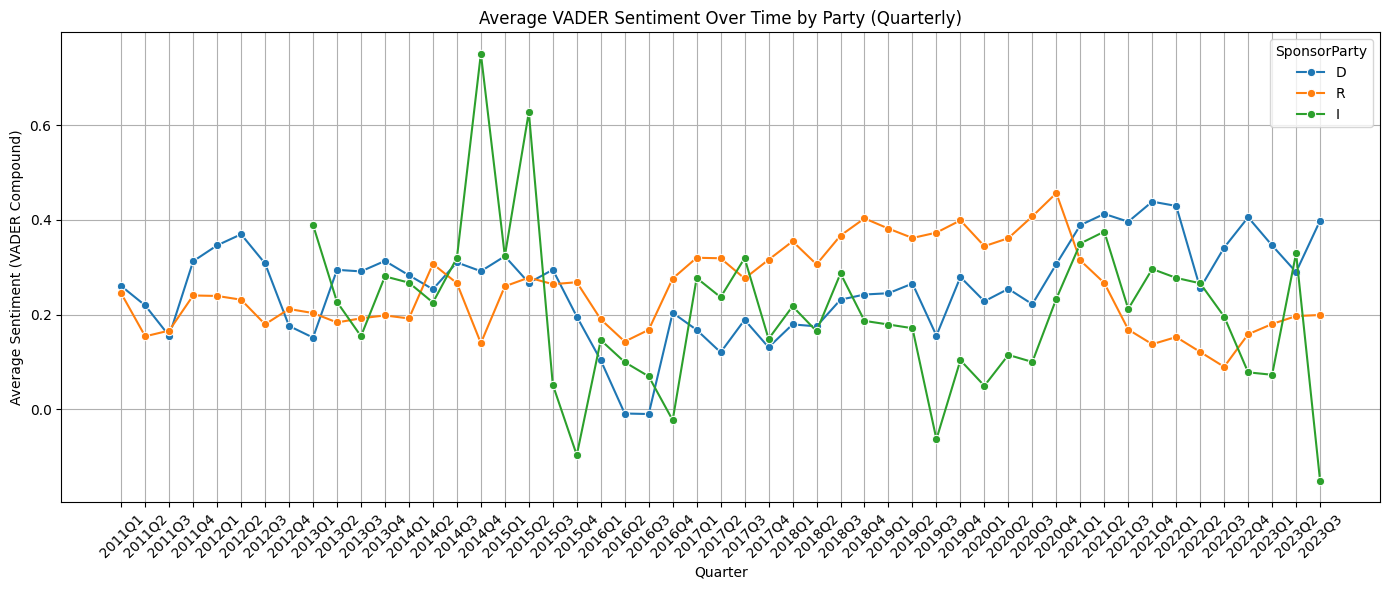

In [ ]:
# Creating Quarter column
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets['Quarter'] = df_tweets['date'].dt.to_period('Q')

# Aggregate sentiment by quarter and party
sentiment_by_quarter_party = df_tweets.groupby(['Quarter', 'SponsorParty'])['VADER_Compound'].mean().reset_index()
sentiment_by_quarter_party['Quarter'] = sentiment_by_quarter_party['Quarter'].astype(str)

# Plot average sentiment over time (by quarter) by party
plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_by_quarter_party, x='Quarter', y='VADER_Compound', hue='SponsorParty', marker='o')
plt.title('Average VADER Sentiment Over Time by Party (Quarterly)')
plt.ylabel('Average Sentiment (VADER Compound)')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

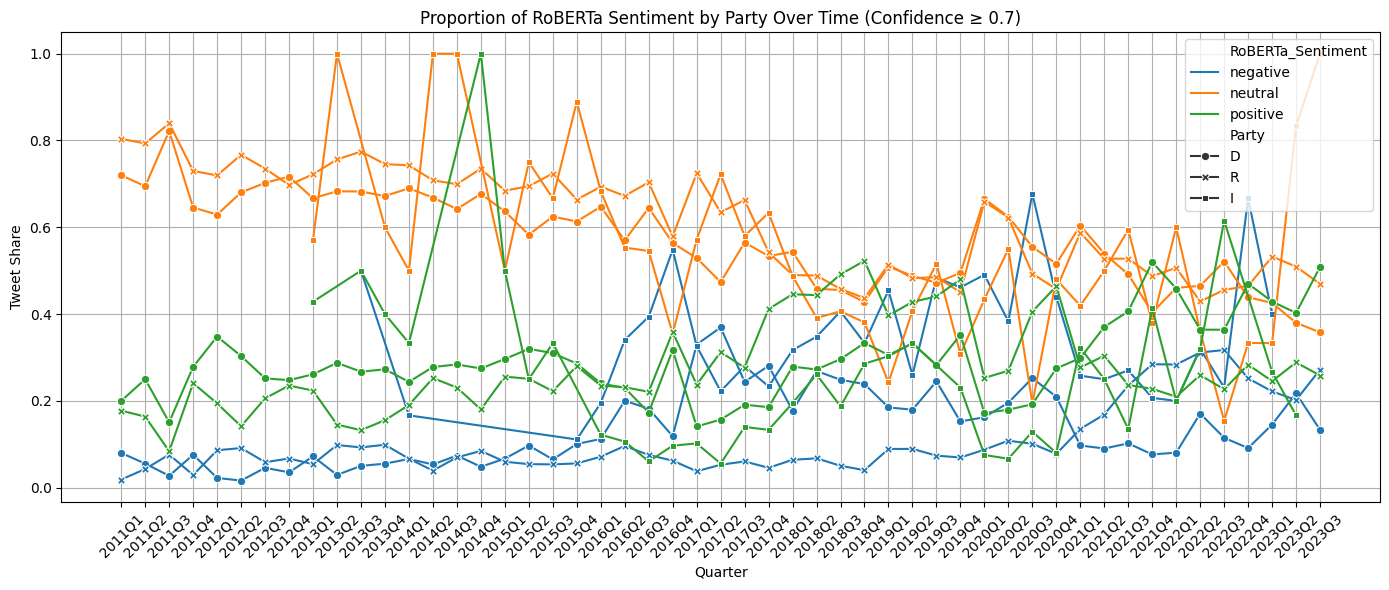

In [ ]:
# Define sentiment label mapping
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'}

# Apply label mapping
df_tweets['RoBERTa_Sentiment'] = df_tweets['RoBERTa_Label'].map(label_map)

# Filter by confidence score threshold
confidence_threshold = 0.7
filtered_df = df_tweets[df_tweets['RoBERTa_Score'] >= confidence_threshold].copy()

# Group by quarter, party, sentiment
sentiment_counts = (
    filtered_df.groupby(['Quarter', 'SponsorParty', 'RoBERTa_Sentiment'])
    .size()
    .reset_index(name='Tweet_Count'))

# Calculate total tweets per party per quarter
total_counts = (
    sentiment_counts.groupby(['Quarter', 'SponsorParty'])['Tweet_Count']
    .sum()
    .reset_index(name='Total_Tweets'))

# Merge totals back into sentiment data
normalized_df = sentiment_counts.merge(total_counts, on=['Quarter', 'SponsorParty'])

# Compute proportion
normalized_df['Tweet_Share'] = normalized_df['Tweet_Count'] / normalized_df['Total_Tweets']

# Clean for plotting
normalized_df.rename(columns={'SponsorParty': 'Party'}, inplace=True)
normalized_df['Quarter'] = normalized_df['Quarter'].astype(str)

# Plot normalized tweet sentiment share
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=normalized_df,
    x='Quarter',
    y='Tweet_Share',
    hue='RoBERTa_Sentiment',
    style='Party',
    markers=True,
    dashes=False
)
plt.title(f'Proportion of RoBERTa Sentiment by Party Over Time (Confidence ≥ {confidence_threshold})')
plt.ylabel('Tweet Share')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# convert LABELs to readable form
label_map = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
df_tweets['RoBERTa_Score_Num'] = df_tweets['RoBERTa_Label'].map(label_map)

# Group by issue and quarter to compute average sentiment
issue_sentiment_over_time = (
    df_tweets.groupby(['BERTTopic', 'Quarter'])['RoBERTa_Score_Num']
    .mean()
    .reset_index()
)

# Compute volatility (standard deviation of sentiment over quarters)
issue_volatility = (
    issue_sentiment_over_time.groupby('BERTTopic')['RoBERTa_Score_Num']
    .std()
    .reset_index()
    .rename(columns={'RoBERTa_Score_Num': 'Sentiment_Volatility'})
    .sort_values(by='Sentiment_Volatility', ascending=False)
)

# Show top 10 most volatile issues
top_volatile_issues = issue_volatility.head(10)['BERTTopic'].tolist()


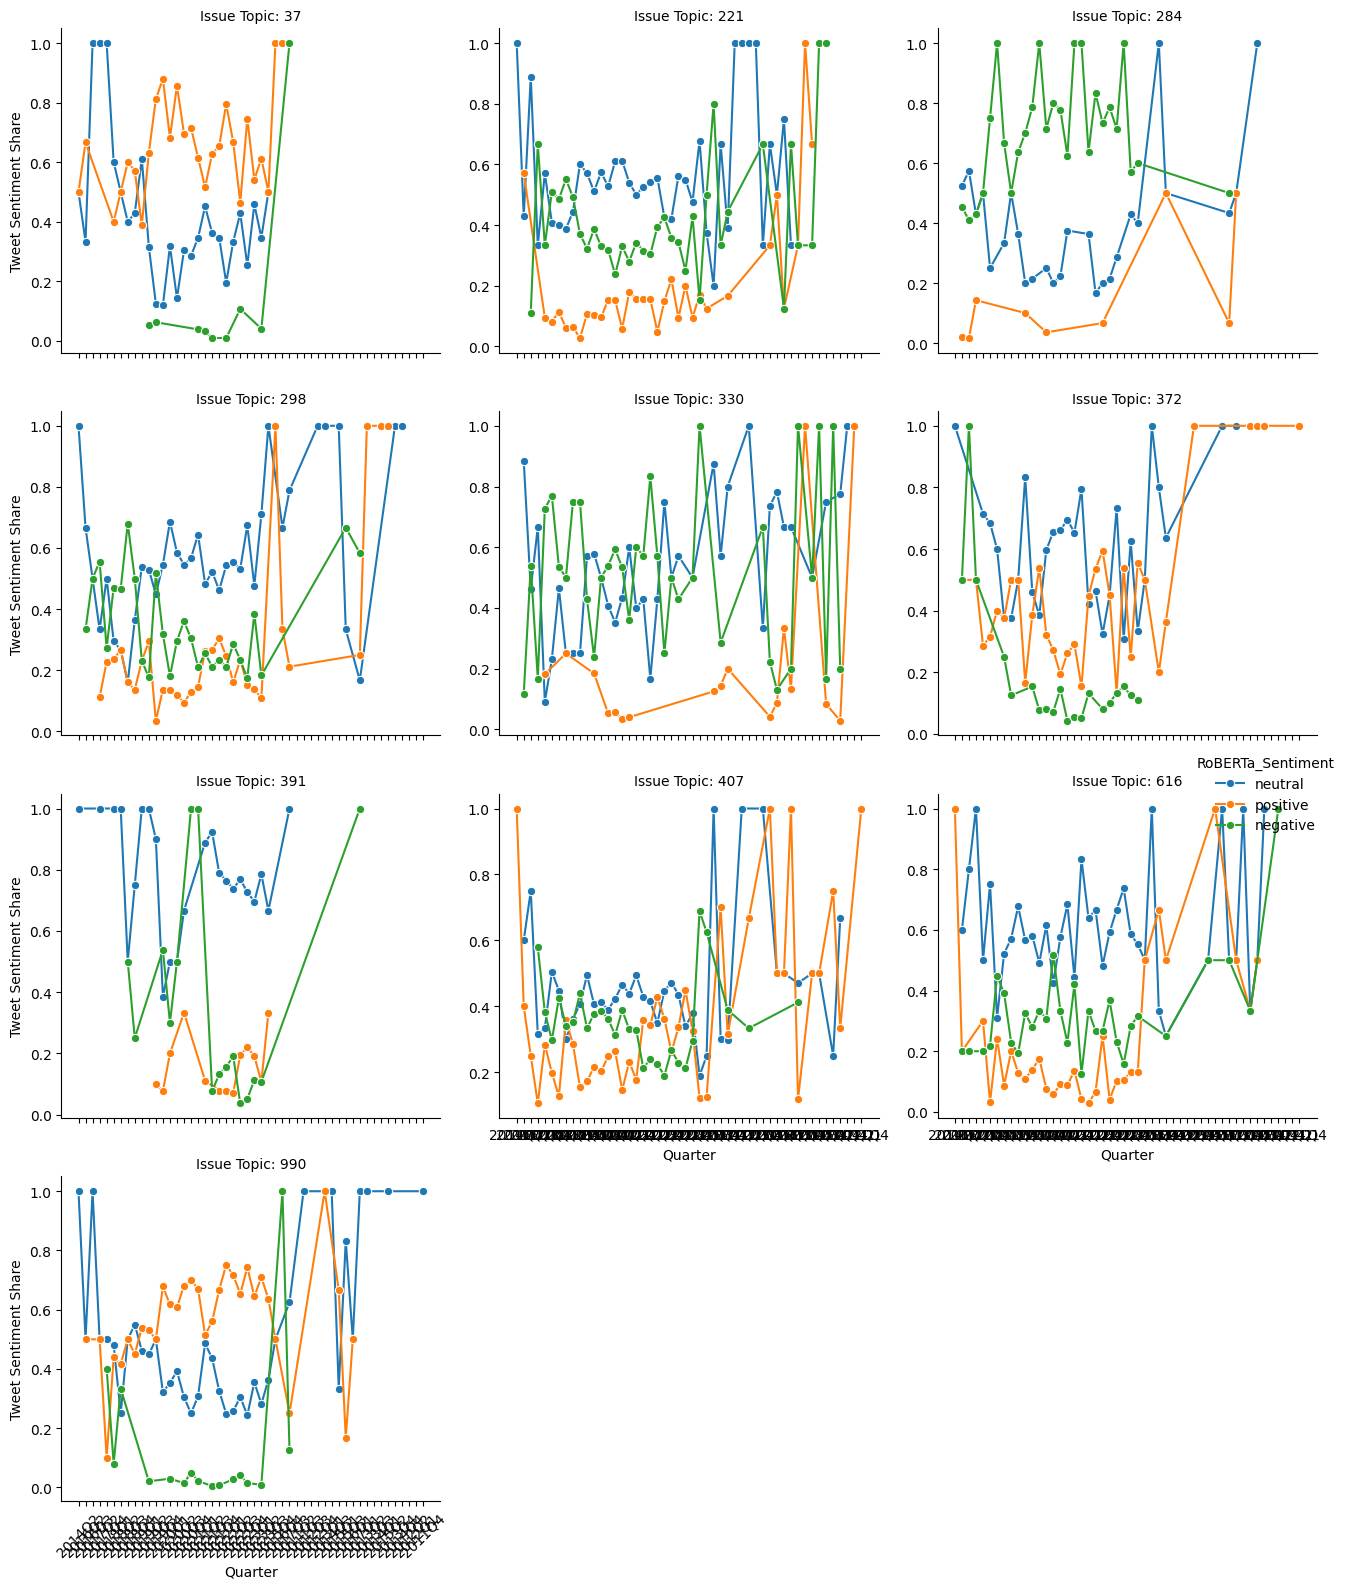

In [ ]:
# Filter for top volatile issues
volatile_df = df_tweets[df_tweets['BERTTopic'].isin(top_volatile_issues)].copy()

# Convert sentiment labels again
label_map = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
volatile_df['RoBERTa_Sentiment'] = volatile_df['RoBERTa_Label'].map(label_map)

# Create quarter column
volatile_df['Quarter'] = pd.to_datetime(volatile_df['date']).dt.to_period('Q').astype(str)

# Group for plotting
plot_data = (
    volatile_df.groupby(['BERTTopic', 'Quarter', 'RoBERTa_Sentiment'])
    .size()
    .reset_index(name='Tweet_Count')
)

# Normalize to percentage per quarter per issue
plot_data['Total'] = plot_data.groupby(['BERTTopic', 'Quarter'])['Tweet_Count'].transform('sum')
plot_data['Tweet_Share'] = plot_data['Tweet_Count'] / plot_data['Total']

# Plot
g = sns.FacetGrid(
    plot_data,
    col='BERTTopic',
    hue='RoBERTa_Sentiment',
    col_wrap=3,
    height=4,
    sharey=False
)
g.map(sns.lineplot, 'Quarter', 'Tweet_Share', marker='o')
g.add_legend()
g.set_titles('Issue Topic: {col_name}')
g.set_axis_labels('Quarter', 'Tweet Sentiment Share')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


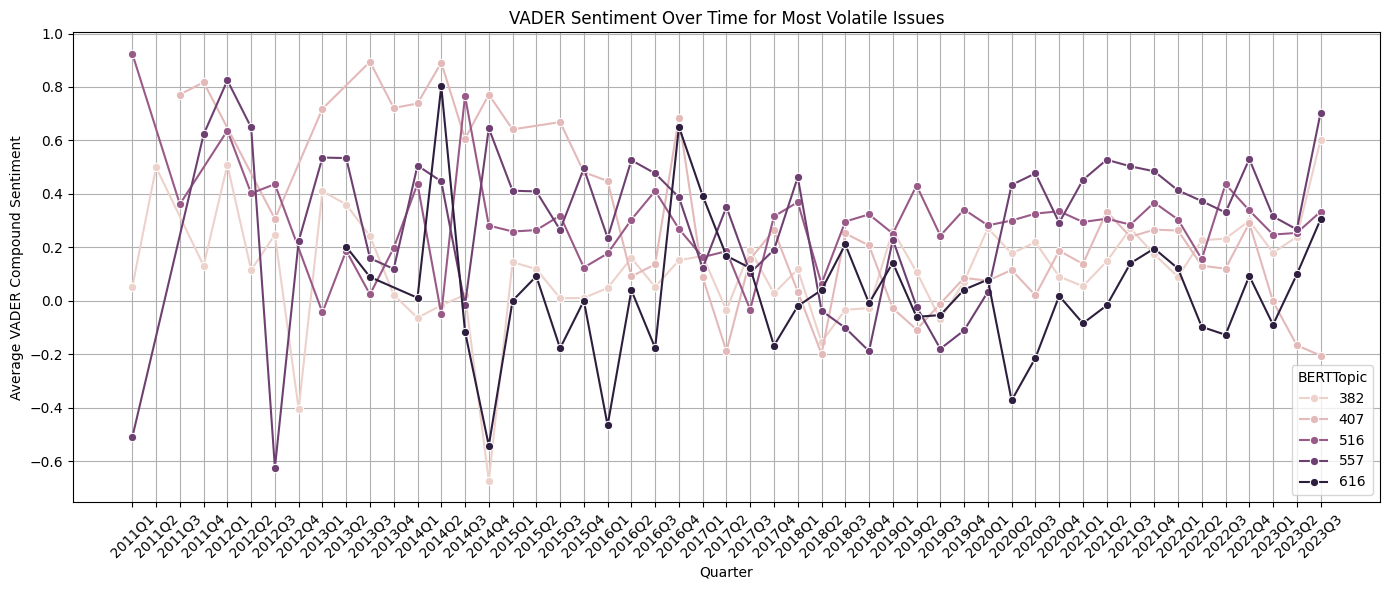

In [ ]:
# Calculate standard deviation of sentiment per issue across all quarters
volatility_by_issue = (
    df_tweets.groupby('BERTTopic')['VADER_Compound']
    .std()
    .reset_index()
    .rename(columns={'VADER_Compound': 'Sentiment_STD'})
    .sort_values(by='Sentiment_STD', ascending=False)
)

# Select top 5 most volatile issues
top_volatile_issues = volatility_by_issue.head(5)['BERTTopic'].tolist()

# Filter original data to only include these issues
volatile_df = df_tweets[df_tweets['BERTTopic'].isin(top_volatile_issues)]

# Group by quarter and issue, then calculate average sentiment
issue_sentiment_trends = (
    volatile_df.groupby(['Quarter', 'BERTTopic'])['VADER_Compound']
    .mean()
    .reset_index()
)

# Convert Period to string for plotting
issue_sentiment_trends['Quarter'] = issue_sentiment_trends['Quarter'].astype(str)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=issue_sentiment_trends,
    x='Quarter',
    y='VADER_Compound',
    hue='BERTTopic',
    marker='o'
)
plt.title('VADER Sentiment Over Time for Most Volatile Issues')
plt.ylabel('Average VADER Compound Sentiment')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


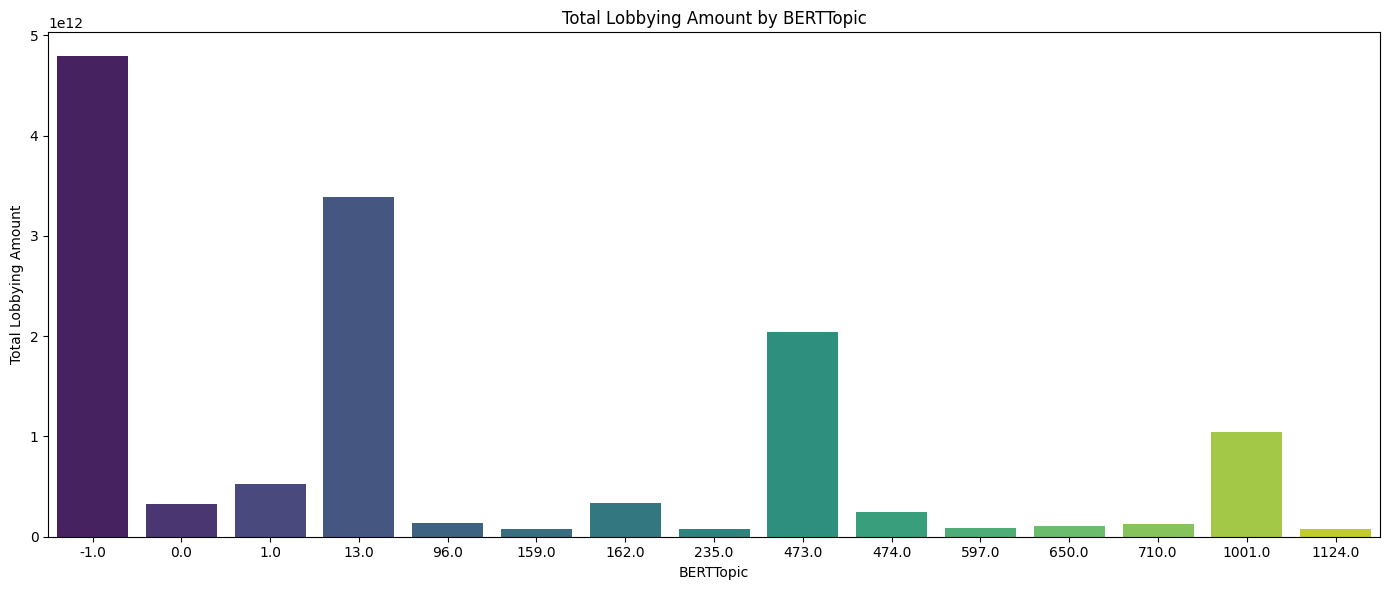

In [ ]:
#  Merge Fact Table with Lobbying Report to get 'Amount' and 'SI_ID'
fact_reports = df_master_table.merge(df_lobbying, on='UniqID', how='left')

# Merge with Issue table to get BERTTopic
fact_reports_with_topics = fact_reports.merge(df_issue_final[['SI_ID', 'BERTopic']], on='SI_ID', how='left')

# Group by BERTTopic and sum the lobbying Amount
topic_lobbying_amount = (
    fact_reports_with_topics.groupby('BERTopic')['Amount']
    .sum()
    .reset_index()
    .rename(columns={'Amount': 'Total_Lobbying_Amount'})
    .sort_values(by='Total_Lobbying_Amount', ascending=False)
)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=topic_lobbying_amount.head(15),
    y='Total_Lobbying_Amount',
    x='BERTopic',
    palette='viridis'
)
plt.title('Total Lobbying Amount by BERTTopic')
plt.xlabel('BERTTopic')
plt.ylabel('Total Lobbying Amount')
plt.tight_layout()
plt.show()


#### Tweets by Topic

In [ ]:
topic_count = df_tweets.groupby('BERTTopic').size()

# Convert the Series to a DataFrame and rename columns
topic_count_df = topic_count.reset_index(name='Tweet_Count')

# Ensure BERTTopic is an integer (or string, if for plotting)
topic_count_df['BERTTopic'] = topic_count_df['BERTTopic'].astype(int)
topic_count_df = topic_count_df.sort_values('Tweet_Count',ascending=False)


# filter for most used topics
top_n = 15
top_topics_df = topic_count_df.head(top_n)


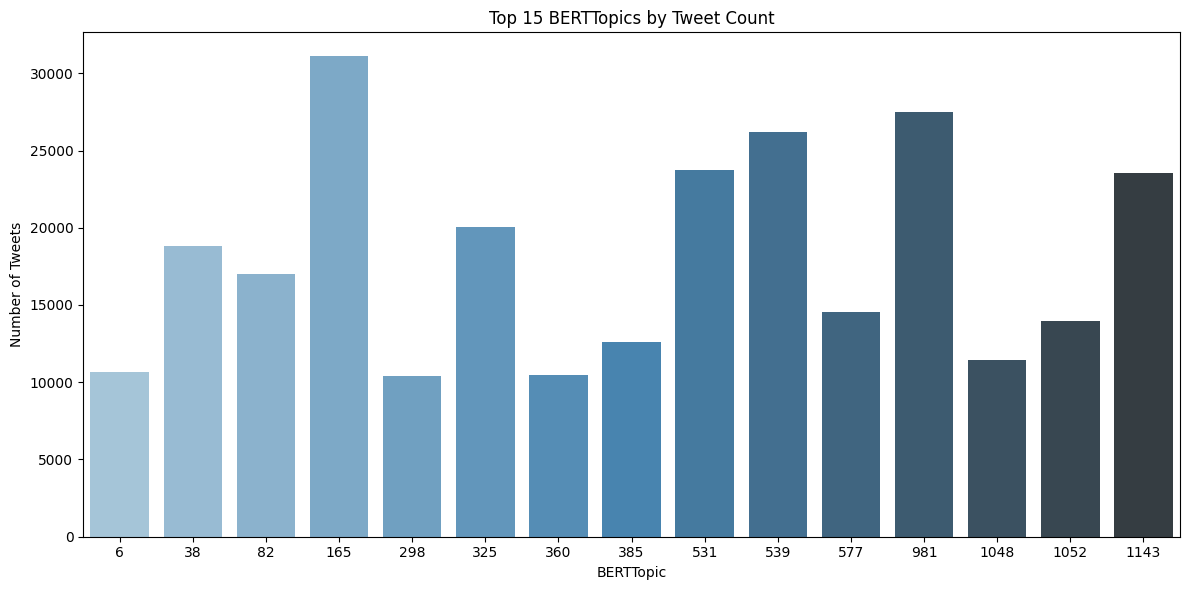

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_topics_df, x='BERTTopic', y='Tweet_Count', palette='Blues_d')
plt.title(f'Top {top_n} BERTTopics by Tweet Count')
plt.xlabel('BERTTopic')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()


#### Comparing Sentiment by Topic With Lobbying Amounts

In [ ]:
# Merge lobbying data with master table to get year
sentiment_analysis_across_topic_time= df_lobbying.merge(
    df_master_table[['UniqID', 'Year','SI_ID']],
    on='UniqID',
    how='left'
) # note: one UniqID can be related to several SI_ID. this makes the amount calculation slightly inaccurate. Skip repeating, SI_ID?

sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time[['UniqID','Amount','Quarter','Year','SI_ID']].drop_duplicates()
sentiment_analysis_across_topic_time

,UniqID,Amount,Quarter,Year,SI_ID
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909947
1,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909948
2,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909949
3,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909950
168,87ff989d-9d12-4fef-84ef-ab69cd616894,21650.0,Q4,2021,2909966
...,...,...,...,...,...
6495646,12a47a18-11f4-43b2-bb1f-3db51e07306b,20000.0,Q4,2022,3077176
6495650,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066813
6495651,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066814
6495668,b0235c16-0a34-4e06-be62-f42a3bf52d6a,80000.0,Q4,2022,3073031


In [ ]:
# retrieving topics for each SI_ID
sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time.merge(
    df_issue_final[['SI_ID','BERTopic','LDATopic']],
    how='left',
    on = 'SI_ID'
)
sentiment_analysis_across_topic_time

# counting number of Specific Issues per UniqID
si_counts = sentiment_analysis_across_topic_time.groupby('UniqID')['SI_ID'].count().reset_index()
si_counts.columns = ['UniqID', 'SI_ID_Count']

sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time.merge(si_counts, on='UniqID', how='left')

# Distribute Amount across SI_IDs
sentiment_analysis_across_topic_time['Distributed_Amount'] = sentiment_analysis_across_topic_time['Amount'] / sentiment_analysis_across_topic_time['SI_ID_Count'] # number will not necessary be accurate for one SI_ID, but total for lobbying report. 

,UniqID,Amount,Quarter,Year,SI_ID,BERTopic,LDATopic
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909947,466.0,9.0
1,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909948,11.0,9.0
2,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909949,-1.0,6.0
3,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909950,74.0,7.0
4,87ff989d-9d12-4fef-84ef-ab69cd616894,21650.0,Q4,2021,2909966,810.0,7.0
...,...,...,...,...,...,...,...
381926,12a47a18-11f4-43b2-bb1f-3db51e07306b,20000.0,Q4,2022,3077176,103.0,7.0
381927,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066813,0.0,3.0
381928,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066814,-1.0,7.0
381929,b0235c16-0a34-4e06-be62-f42a3bf52d6a,80000.0,Q4,2022,3073031,748.0,8.0


In [33]:
# convering data type of quarter and year to ensure they're matching. 
sentiment_analysis_across_topic_time['Quarter'] = sentiment_analysis_across_topic_time['Quarter'].astype(str)
sentiment_analysis_across_topic_time['Year'] = sentiment_analysis_across_topic_time['Year'].astype(str)

# Combine Year and Quarter
sentiment_analysis_across_topic_time['Quarter'] = sentiment_analysis_across_topic_time['Year'] + sentiment_analysis_across_topic_time['Quarter']
sentiment_analysis_across_topic_time['Quarter'] = pd.PeriodIndex(sentiment_analysis_across_topic_time['Quarter'], freq='Q')


In [35]:
# grouping amount by topic and date
lobbying_by_topic = (
    sentiment_analysis_across_topic_time[sentiment_analysis_across_topic_time['BERTopic'] != -1]  # remove unclassified
      .groupby(['BERTopic', 'Quarter'])
      ['Distributed_Amount']
      .sum()
      .reset_index()
      .rename(columns={'Distributed_Amount': 'Total_Lobbying_Amount'})
)


In [30]:
# Convert to datetime and extract Quarter
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets['Quarter'] = df_tweets['date'].dt.to_period('Q').astype(str)

# Group by topic and quarter for average sentiment (can switch to RoBERTa if needed)
sentiment_agg = (
    df_tweets.groupby(['BERTTopic', 'Quarter'])['VADER_Compound']
    .mean()
    .reset_index()
    .rename(columns={'VADER_Compound': 'Avg_Sentiment'})
)


In [48]:
sentiment_agg = sentiment_agg.rename(columns={'BERTTopic': 'BERTopic'})

In [53]:
sentiment_agg['Quarter'] = pd.PeriodIndex(sentiment_agg['Quarter'], freq='Q')
lobbying_by_topic['Quarter'] = pd.PeriodIndex(lobbying_by_topic['Quarter'], freq='Q')

# Merge on BERTTopic and Quarter
merged_df = pd.merge(sentiment_agg, lobbying_by_topic, on=['BERTopic', 'Quarter'], how='inner')


In [57]:
correlations = merged_df.groupby('BERTopic')[
    ['Total_Lobbying_Amount', 'Avg_Sentiment']
].corr().iloc[0::2, 1].reset_index()
correlations.columns = ['BERTTopic', '_', 'Correlation']


In [59]:
# Sort by absolute correlation and pick top 10 topics
top_n = 10
top_corr_topics = correlations.copy()
top_corr_topics['abs_corr'] = top_corr_topics['Correlation'].abs()
top_corr_topics = top_corr_topics.sort_values(by='abs_corr', ascending=False).head(top_n)
top_topics_list = top_corr_topics['BERTTopic'].tolist()

filtered_merged = merged_df[merged_df['BERTopic'].isin(top_topics_list)]


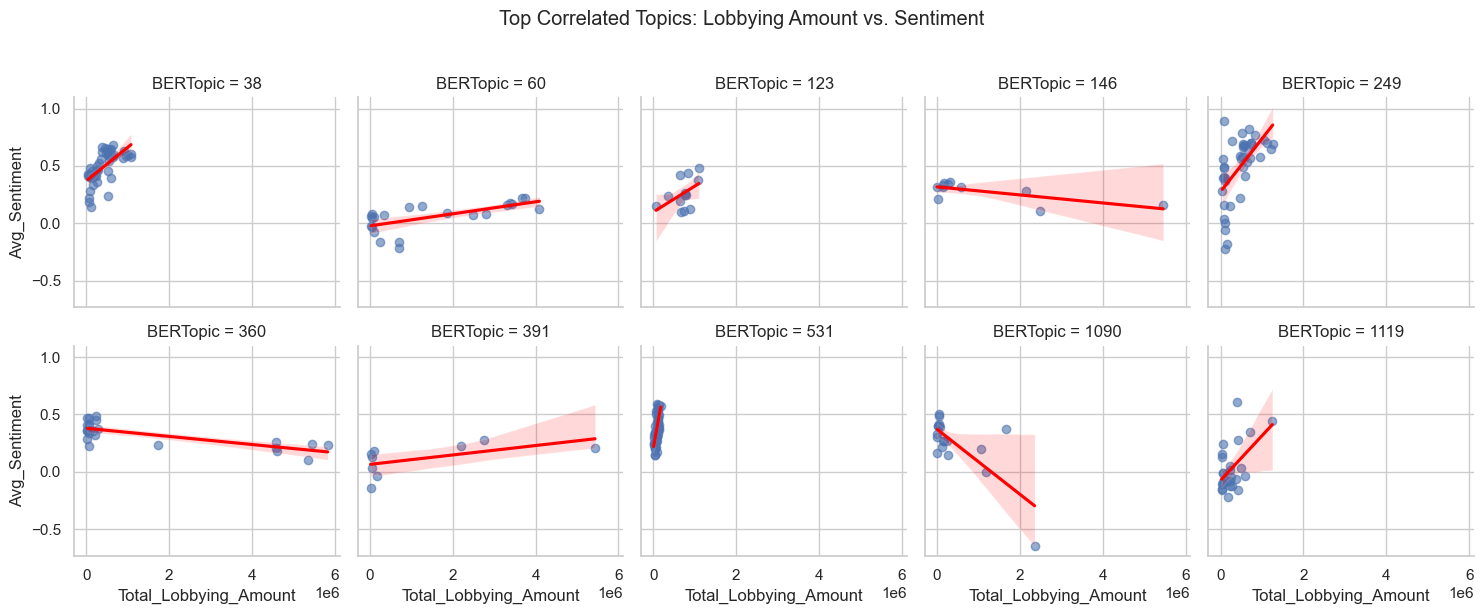

In [60]:

sns.set(style='whitegrid')
sns.lmplot(
    data=filtered_merged,
    x='Total_Lobbying_Amount',
    y='Avg_Sentiment',
    col='BERTopic',
    col_wrap=5,   # adjust depending on how many plots you want per row
    height=3,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)

plt.suptitle('Top Correlated Topics: Lobbying Amount vs. Sentiment', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Collect results in a list
corr_results = []

for topic in merged_df['BERTopic'].unique():
    sub_df = merged_df[merged_df['BERTopic'] == topic]
    
    if len(sub_df) >= 3:  # avoid very small samples
        r, p = pearsonr(sub_df['Total_Lobbying_Amount'], sub_df['Avg_Sentiment'])
        corr_results.append({'BERTopic': topic, 'Pearson_r': r, 'p_value': p, 'n_obs': len(sub_df)})

# Sort by significance
df_corr_stats = pd.DataFrame(corr_results)
df_corr_stats = df_corr_stats.sort_values('p_value')


/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [64]:
df_corr_stats

,BERTopic,Pearson_r,p_value,n_obs
86,531,0.655415,5.747022e-07,47
14,38,0.641269,6.893359e-07,49
69,360,-0.758634,2.722940e-05,23
49,249,0.588249,4.187051e-05,42
158,1090,-0.749577,2.201675e-04,19
...,...,...,...,...
137,922,-0.014522,9.607018e-01,14
57,291,-0.003735,9.858612e-01,25
107,697,-0.002377,9.886985e-01,38
119,791,-0.000443,9.977228e-01,44
